# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import math

# sklearn for utilization
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import recall_score, precision_score, fbeta_score
from sklearn.model_selection import StratifiedKFold

# modelling for ensemble method
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# visualization purpose
import matplotlib.pyplot as plt

# utils
import pickle
import random
import warnings
warnings.filterwarnings("ignore")

# import our ensemble stacking model here
from models.model_ensembles import EnsembleStacking

# import our genetic algorithm model here
from models.genetic_algorithm_rouellete import GeneticAlgorithm

In [2]:
# for reproducecibility
random_state = 60251014
random.seed(random_state)

# Load Data After Preprocessing
***
Load data Breast Cancer Prognosis after cleaned and preprocessed

In [3]:
breast_cancer_preprocessed = pickle.load(open('../dataset/preprocessed_breast_cancer_data.pkl', 'rb'))

# prognosis breast cancer dataset
prognosis_X_train_original = breast_cancer_preprocessed['prognosis']['original']['X_train']
prognosis_X_train_downsampling = breast_cancer_preprocessed['prognosis']['downsampling']['X_train']
prognosis_X_train_upsampling = breast_cancer_preprocessed['prognosis']['upsampling']['X_train']

prognosis_y_train_original = breast_cancer_preprocessed['prognosis']['original']['y_train']
prognosis_y_train_downsampling = breast_cancer_preprocessed['prognosis']['downsampling']['y_train']
prognosis_y_train_upsampling = breast_cancer_preprocessed['prognosis']['upsampling']['y_train']

prognosis_X_test_original = breast_cancer_preprocessed['prognosis']['original']['X_test']
prognosis_y_test_original = breast_cancer_preprocessed['prognosis']['original']['y_test']

# Defining Global Variables

In [4]:
kfold = StratifiedKFold(n_splits=5, random_state=45, shuffle=True)


# Genetic Algorithm global variables
number_of_chromosome = 45
maximum_generations = 30
crossover_rate = 0.85
mutation_rate = 0.01
convergence = 5

# Defining Global Functions

In [5]:
def create_new_input_features(ensemble_classifiers, X, y):
    all_predicted_results = dict()
    list_of_majority_voting_each_models = list()
    list_of_models = list()

    for model_name, models in ensemble_classifiers.items():
        # voting scenario for new data input prepration for ANN model
        if len(models)!=0:
            all_predicted_results[model_name] = dict()
            for sub_model_name, dict_models in models.items():
                all_predicted_results[model_name][sub_model_name] = dict_models['train'].predict(X)

            # make dataframe for 5 model prediction results on X and get the mode label for that 5 prediction
            model_df_voting = pd.DataFrame(all_predicted_results[model_name]).mode(axis=1)[0]
            list_of_models.append('majority_vote_from_'+model_name)
            list_of_majority_voting_each_models.append(model_df_voting)
            
    new_input_features = pd.concat(list_of_majority_voting_each_models, axis=1)
    new_input_features.columns = list_of_models
    new_input_features['ground_truth'] = y.copy()
            
    return new_input_features

In [6]:
def print_model_experiment_results(name_of_scenario, y_test, y_pred):
    print('\t\t' + '='*30)
    print('\t\tHASIl UJI COBA {}'.format(name_of_scenario.upper()))
    print('\t\t' + '='*30)
    print("\tAkurasi Score: ", accuracy_score(y_test, y_pred))
    print("\tMacro Recall Score: ", recall_score(y_test, y_pred, average='macro'))
    print("\tMacro Precision Score: ", precision_score(y_test, y_pred, average='macro'))
    print("\tMacro F1-score Score: ", fbeta_score(y_test, y_pred, beta=1, average='macro'))
    print("\tMacro F2-score Score: ", fbeta_score(y_test, y_pred, beta=2, average='macro'))
    print("\tMacro F0.5-score Score: ", fbeta_score(y_test, y_pred, beta=0.5, average='macro'))
    
    print()
    print()
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    plt.figure(figsize=(14,8))
    disp.plot()
    plt.show()

# Modelling Ensemble Classifiers for Prognosis Breast Cancer using Genetic Optimization

## Without Data Sampling Method (Original)

### GA Optimization using Data without sampling

ITERASI KE 0 | BEST FITNESS = 0.7953965053763441
ITERASI KE 1 | BEST FITNESS = 0.7811841397849462
ITERASI KE 2 | BEST FITNESS = 0.7419677419354839
ITERASI KE 3 | BEST FITNESS = 0.7438427419354838
ITERASI KE 4 | BEST FITNESS = 0.7166680107526882
ITERASI KE 5 | BEST FITNESS = 0.7156263440860215
ITERASI KE 6 | BEST FITNESS = 0.7742258064516129
ITERASI KE 7 | BEST FITNESS = 0.7771424731182796
ITERASI KE 8 | BEST FITNESS = 0.7418844086021505
ITERASI KE 9 | BEST FITNESS = 0.7893131720430108
ITERASI KE 10 | BEST FITNESS = 0.7762674731182795
ITERASI KE 11 | BEST FITNESS = 0.7742674731182795
ITERASI KE 12 | BEST FITNESS = 0.7762674731182795
ITERASI KE 13 | BEST FITNESS = 0.7792674731182796
ITERASI KE 14 | BEST FITNESS = 0.7742674731182795
ITERASI KE 15 | BEST FITNESS = 0.7772674731182796
ITERASI KE 16 | BEST FITNESS = 0.7732674731182796
ITERASI KE 17 | BEST FITNESS = 0.7742674731182795
ITERASI KE 18 | BEST FITNESS = 0.7772674731182796
ITERASI KE 19 | BEST FITNESS = 0.7782674731182795
ITERASI KE

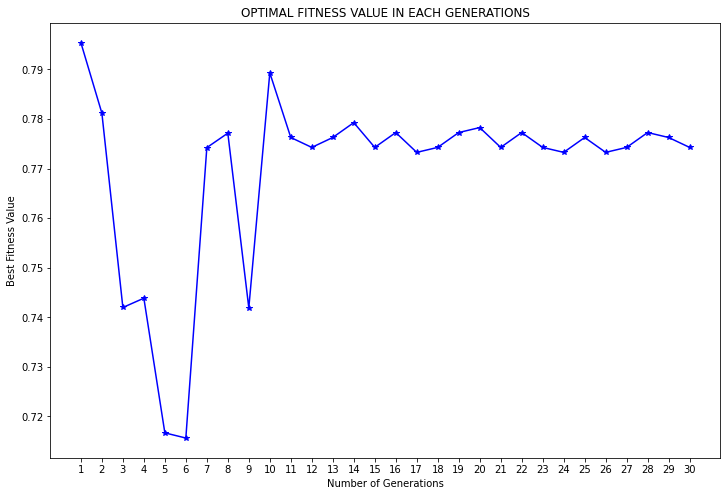

[[[2.1, 'linear', 'scale', 0.001],
  ['log_loss', 'best', 3, 6, 3],
  ['l1', 'saga', 125, 0.001],
  [(75, 75), 'tanh', 'lbfgs', 1e-05, 32, 'constant', 0.004, 300]],
 0.7742674731182795]

In [7]:
ga_model_original = GeneticAlgorithm(
    X_train=prognosis_X_train_original,
    y_train=prognosis_y_train_original,
    kfold=kfold,
    number_of_chromosome=number_of_chromosome,
    maximum_generations=maximum_generations,
    crossover_rate=crossover_rate,
    mutation_rate=mutation_rate,
    convergence=convergence
)
last_populations_original = ga_model_original.train()

# plot best fitness value in each generation
ga_model_original.plot_best_fitness_values()

# get the last generation for best solutions
best_hyperparams_genetic_algorithm_solution = last_populations_original[0]
best_hyperparams_svm = best_hyperparams_genetic_algorithm_solution[0][0]
best_hyperparams_dt = best_hyperparams_genetic_algorithm_solution[0][1]
best_hyperparams_logreg = best_hyperparams_genetic_algorithm_solution[0][2]
best_hyperparams_ann = best_hyperparams_genetic_algorithm_solution[0][3]

best_hyperparams_genetic_algorithm_solution

### Create Stacking ML Ensemble using 5-fold cross-validation

In [8]:
# create ensembles stacking method using GA hyperparameter optimized
genetic_algorithm_ensemble_classifiers_prognosis_original = EnsembleStacking(
    prognosis_X_train_original,
    prognosis_y_train_original,
    prognosis_X_test_original,
    prognosis_y_test_original,
    kfold,
    svm_params={
        'C': best_hyperparams_svm[0],
        'kernel': best_hyperparams_svm[1],
        'gamma': best_hyperparams_svm[2],
        'tol': best_hyperparams_svm[3],
    },
    dt_params={
        'criterion': best_hyperparams_dt[0],
        'splitter': best_hyperparams_dt[1],
        'max_depth': best_hyperparams_dt[2],
        'min_samples_split': best_hyperparams_dt[3],
        'min_samples_leaf': best_hyperparams_dt[4],
    },
    logreg_params={
        'penalty': best_hyperparams_logreg[0],
        'solver': best_hyperparams_logreg[1],
        'max_iter': best_hyperparams_logreg[2],
        'tol': best_hyperparams_logreg[3],
    }
).train_ensemble()

In [9]:
# create dataframe for easy understanding from ensemble classifiers stacking results
genetic_algorithm_ensemble_classifiers_results_prognosis_original = list()
for model in genetic_algorithm_ensemble_classifiers_prognosis_original.keys():
    genetic_algorithm_ensemble_classifiers_results_prognosis_original.append(
        pd.DataFrame(genetic_algorithm_ensemble_classifiers_prognosis_original[model]).transpose().sort_values(by=['testing'], ascending=False))

# concat all dataframe results
genetic_algorithm_ensemble_classifiers_results_prognosis_original = pd.concat(genetic_algorithm_ensemble_classifiers_results_prognosis_original, axis=0)
genetic_algorithm_ensemble_classifiers_results_prognosis_original

,train,training,validation,testing
model-3,"SVC(C=2.1, kernel='linear')",0.804878,0.83871,0.871795
model-5,"SVC(C=2.1, kernel='linear')",0.846774,0.733333,0.794872
model-2,"SVC(C=2.1, kernel='linear')",0.772358,0.774194,0.74359
model-1,"SVC(C=2.1, kernel='linear')",0.772358,0.774194,0.717949
model-4,"SVC(C=2.1, kernel='linear')",0.772358,0.774194,0.717949
model-5,"LogisticRegression(max_iter=125, penalty='l1',...",0.790323,0.766667,0.769231
model-3,"LogisticRegression(max_iter=125, penalty='l1',...",0.780488,0.774194,0.74359
model-1,"LogisticRegression(max_iter=125, penalty='l1',...",0.772358,0.774194,0.717949
model-2,"LogisticRegression(max_iter=125, penalty='l1',...",0.772358,0.774194,0.717949
model-4,"LogisticRegression(max_iter=125, penalty='l1',...",0.772358,0.774194,0.717949


### Create New Input Training from stacking ensemble ML

In [10]:
genetic_algorithm_new_input_training_features_prognosis_original = create_new_input_features(
    genetic_algorithm_ensemble_classifiers_prognosis_original, 
    prognosis_X_train_original,
    prognosis_y_train_original
)

In [11]:
genetic_algorithm_new_input_training_features_prognosis_original.head()

,majority_vote_from_svm,majority_vote_from_logreg,majority_vote_from_naive_bayes,majority_vote_from_decision_tree,ground_truth
0,0,0,0,0,0
1,0,0,0,1,1
2,0,0,0,0,0
3,0,0,0,1,1
4,0,0,0,0,0


### Feed New Input Features into ANN Model

In [12]:
# split X and y from new_input_features before feeding to ANN
new_X_train = genetic_algorithm_new_input_training_features_prognosis_original.drop([
                                                                                    'ground_truth'], axis=1)
new_y_train = genetic_algorithm_new_input_training_features_prognosis_original[
    'ground_truth']

# feed new X and new y into ANN
genetic_algorithm_ann_model_prognosis_original = MLPClassifier(
    hidden_layer_sizes=best_hyperparams_ann[0],
    activation=best_hyperparams_ann[1],
    solver=best_hyperparams_ann[2],
    alpha=best_hyperparams_ann[3],
    batch_size=best_hyperparams_ann[4],
    learning_rate=best_hyperparams_ann[5],
    learning_rate_init=best_hyperparams_ann[6],
    max_iter=best_hyperparams_ann[7]
)
genetic_algorithm_ann_model_prognosis_original.fit(new_X_train, new_y_train)
predicted_ann_train_prognosis_original = genetic_algorithm_ann_model_prognosis_original.predict(
    new_X_train)

print("Final Accuracy Score [Mls Ensembles + ANN] on Training Prognosis Dataset (Original) = ",
      accuracy_score(new_y_train, predicted_ann_train_prognosis_original))

Final Accuracy Score [Mls Ensembles + ANN] on Training Prognosis Dataset (Original) =  0.8766233766233766


## With Data Sampling Method (Upsampling)

### GA Optimization using Data with Upsampling

ITERASI KE 0 | BEST FITNESS = 0.6019736842105263
ITERASI KE 1 | BEST FITNESS = 0.6036184210526316
ITERASI KE 2 | BEST FITNESS = 0.7401315789473684
ITERASI KE 3 | BEST FITNESS = 0.7289473684210527
ITERASI KE 4 | BEST FITNESS = 0.712938596491228
ITERASI KE 5 | BEST FITNESS = 0.7111842105263159
ITERASI KE 6 | BEST FITNESS = 0.7414473684210526
ITERASI KE 7 | BEST FITNESS = 0.5729166666666667
ITERASI KE 8 | BEST FITNESS = 0.7357456140350878
ITERASI KE 9 | BEST FITNESS = 0.7495614035087719
ITERASI KE 10 | BEST FITNESS = 0.7337719298245615
ITERASI KE 11 | BEST FITNESS = 0.7535087719298246
ITERASI KE 12 | BEST FITNESS = 0.6219298245614036
ITERASI KE 13 | BEST FITNESS = 0.6232456140350877
ITERASI KE 14 | BEST FITNESS = 0.6883771929824563
ITERASI KE 15 | BEST FITNESS = 0.6212719298245615
ITERASI KE 16 | BEST FITNESS = 0.7574561403508773
ITERASI KE 17 | BEST FITNESS = 0.7535087719298246
ITERASI KE 18 | BEST FITNESS = 0.7430921052631579
ITERASI KE 19 | BEST FITNESS = 0.7502192982456141
ITERASI KE 

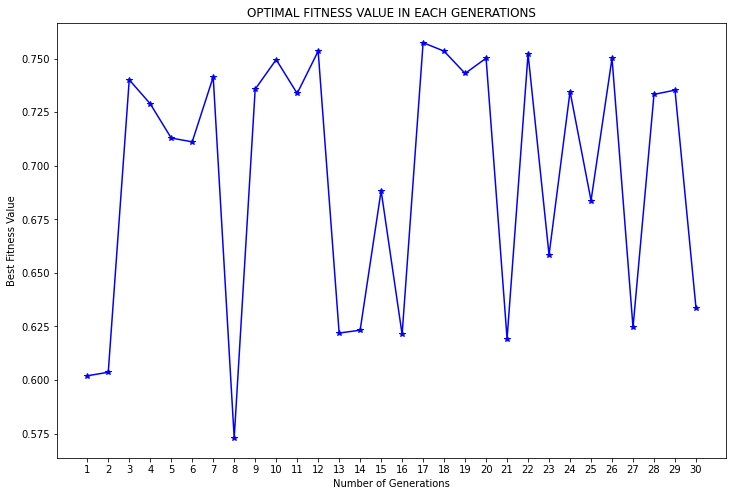

[[[1.8, 'rbf', 'auto', 0.01],
  ['log_loss', 'random', 1, 2, 1],
  ['none', 'saga', 75, 0.001],
  [(50, 100), 'tanh', 'lbfgs', 0.0001, 64, 'constant', 0.005, 300]],
 0.6336622807017542]

In [13]:
ga_model_upsampling = GeneticAlgorithm(
    X_train=prognosis_X_train_upsampling,
    y_train=prognosis_y_train_upsampling,
    kfold=kfold,
    number_of_chromosome=number_of_chromosome,
    maximum_generations=maximum_generations,
    crossover_rate=crossover_rate,
    mutation_rate=mutation_rate,
    convergence=convergence
)
last_populations_upsampling = ga_model_upsampling.train()

# plot best fitness value in each generation
ga_model_upsampling.plot_best_fitness_values()

# get the last generation for best solutions
best_hyperparams_genetic_algorithm_solution = last_populations_upsampling[0]
best_hyperparams_svm = best_hyperparams_genetic_algorithm_solution[0][0]
best_hyperparams_dt = best_hyperparams_genetic_algorithm_solution[0][1]
best_hyperparams_logreg = best_hyperparams_genetic_algorithm_solution[0][2]
best_hyperparams_ann = best_hyperparams_genetic_algorithm_solution[0][3]

best_hyperparams_genetic_algorithm_solution

### Create Stacking ML Ensemble using 5-fold cross-validation

In [14]:
# create ensembles stacking method using GA hyperparameter optimized
genetic_algorithm_ensemble_classifiers_prognosis_upsampling = EnsembleStacking(
    prognosis_X_train_upsampling,
    prognosis_y_train_upsampling,
    prognosis_X_test_original,
    prognosis_y_test_original,
    kfold,
    svm_params={
        'C': best_hyperparams_svm[0],
        'kernel': best_hyperparams_svm[1],
        'gamma': best_hyperparams_svm[2],
        'tol': best_hyperparams_svm[3],
    },
    dt_params={
        'criterion': best_hyperparams_dt[0],
        'splitter': best_hyperparams_dt[1],
        'max_depth': best_hyperparams_dt[2],
        'min_samples_split': best_hyperparams_dt[3],
        'min_samples_leaf': best_hyperparams_dt[4],
    },
    logreg_params={
        'penalty': best_hyperparams_logreg[0],
        'solver': best_hyperparams_logreg[1],
        'max_iter': best_hyperparams_logreg[2],
        'tol': best_hyperparams_logreg[3],
    }
).train_ensemble()

In [15]:
# create dataframe for easy understanding from ensemble classifiers stacking results
genetic_algorithm_ensemble_classifiers_results_prognosis_upsampling = list()
for model in genetic_algorithm_ensemble_classifiers_prognosis_upsampling.keys():
    genetic_algorithm_ensemble_classifiers_results_prognosis_upsampling.append(pd.DataFrame(genetic_algorithm_ensemble_classifiers_prognosis_upsampling[model]).transpose().sort_values(by=['testing'], ascending=False))

# concat all dataframe results
genetic_algorithm_ensemble_classifiers_results_prognosis_upsampling = pd.concat(genetic_algorithm_ensemble_classifiers_results_prognosis_upsampling, axis=0)
genetic_algorithm_ensemble_classifiers_results_prognosis_upsampling

,train,training,validation,testing
model-2,"SVC(C=1.8, gamma='auto', tol=0.01)",0.705263,0.708333,0.717949
model-4,"SVC(C=1.8, gamma='auto', tol=0.01)",0.691099,0.574468,0.666667
model-5,"SVC(C=1.8, gamma='auto', tol=0.01)",0.706806,0.617021,0.666667
model-1,"SVC(C=1.8, gamma='auto', tol=0.01)",0.7,0.5625,0.641026
model-3,"SVC(C=1.8, gamma='auto', tol=0.01)",0.657895,0.75,0.589744
model-2,"LogisticRegression(max_iter=75, penalty='none'...",0.836842,0.791667,0.794872
model-3,"LogisticRegression(max_iter=75, penalty='none'...",0.8,0.875,0.769231
model-1,"LogisticRegression(max_iter=75, penalty='none'...",0.815789,0.6875,0.717949
model-4,"LogisticRegression(max_iter=75, penalty='none'...",0.795812,0.808511,0.717949
model-5,"LogisticRegression(max_iter=75, penalty='none'...",0.858639,0.765957,0.717949


### Create New Input Training from stacking ensemble ML

In [16]:
genetic_algorithm_new_input_training_features_prognosis_upsampling = create_new_input_features(
    genetic_algorithm_ensemble_classifiers_prognosis_upsampling, 
    prognosis_X_train_upsampling,
    prognosis_y_train_upsampling
)

In [17]:
genetic_algorithm_new_input_training_features_prognosis_upsampling.head()

,majority_vote_from_svm,majority_vote_from_logreg,majority_vote_from_naive_bayes,majority_vote_from_decision_tree,ground_truth
0,0,0,1,0,0
1,0,1,1,0,1
2,0,1,0,1,1
3,1,0,1,0,0
4,0,0,0,0,0


### Feed New Input Features into ANN Model

In [18]:
# split X and y from new_input_features before feeding to ANN
new_X_train = genetic_algorithm_new_input_training_features_prognosis_upsampling.drop([
                                                                                    'ground_truth'], axis=1)
new_y_train = genetic_algorithm_new_input_training_features_prognosis_upsampling[
    'ground_truth']

# feed new X and new y into ANN
genetic_algorithm_ann_model_prognosis_upsampling = MLPClassifier(
    hidden_layer_sizes=best_hyperparams_ann[0],
    activation=best_hyperparams_ann[1],
    solver=best_hyperparams_ann[2],
    alpha=best_hyperparams_ann[3],
    batch_size=best_hyperparams_ann[4],
    learning_rate=best_hyperparams_ann[5],
    learning_rate_init=best_hyperparams_ann[6],
    max_iter=best_hyperparams_ann[7]
)
genetic_algorithm_ann_model_prognosis_upsampling.fit(new_X_train, new_y_train)
predicted_ann_train_prognosis_upsampling = genetic_algorithm_ann_model_prognosis_upsampling.predict(
    new_X_train)

print("Final Accuracy Score [Mls Ensembles + ANN] on Training Prognostic Dataset (Upsampling) = ",
      accuracy_score(new_y_train, predicted_ann_train_prognosis_upsampling))

Final Accuracy Score [Mls Ensembles + ANN] on Training Prognostic Dataset (Upsampling) =  0.8445378151260504


## With Data Sampling Method (Downsampling)

### GA Optimization using data with Downsampling

ITERASI KE 0 | BEST FITNESS = 0.5939664502164502
ITERASI KE 1 | BEST FITNESS = 0.6140422077922079
ITERASI KE 2 | BEST FITNESS = 0.6699404761904761
ITERASI KE 3 | BEST FITNESS = 0.5477272727272727
ITERASI KE 4 | BEST FITNESS = 0.6185064935064936
ITERASI KE 5 | BEST FITNESS = 0.49364177489177485
ITERASI KE 6 | BEST FITNESS = 0.6024891774891775
ITERASI KE 7 | BEST FITNESS = 0.6853896103896104
ITERASI KE 8 | BEST FITNESS = 0.5691558441558442
ITERASI KE 9 | BEST FITNESS = 0.6047619047619048
ITERASI KE 10 | BEST FITNESS = 0.6585768398268399
ITERASI KE 11 | BEST FITNESS = 0.53125
ITERASI KE 12 | BEST FITNESS = 0.5830627705627704
ITERASI KE 13 | BEST FITNESS = 0.4622835497835498
ITERASI KE 14 | BEST FITNESS = 0.5044372294372294
ITERASI KE 15 | BEST FITNESS = 0.5741612554112554
ITERASI KE 16 | BEST FITNESS = 0.569237012987013
ITERASI KE 17 | BEST FITNESS = 0.645211038961039
ITERASI KE 18 | BEST FITNESS = 0.6404761904761904
ITERASI KE 19 | BEST FITNESS = 0.578517316017316
ITERASI KE 20 | BEST FI

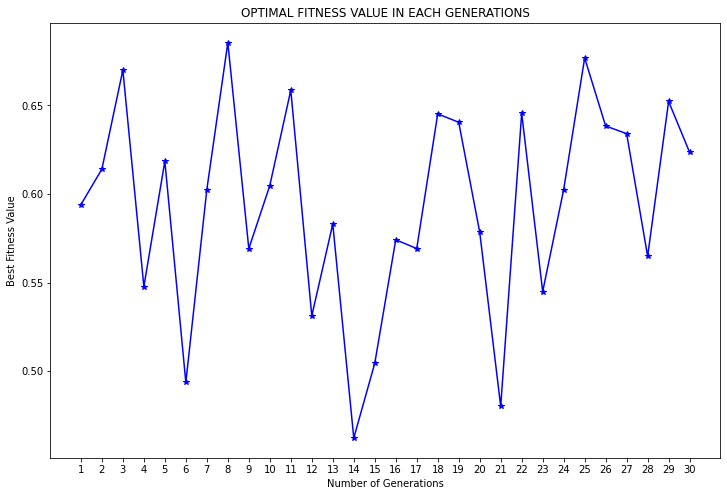

[[[1.4, 'sigmoid', 'auto', 0.01],
  ['gini', 'random', 4, 2, 3],
  ['l1', 'liblinear', 100, 1e-05],
  [(100, 25), 'identity', 'sgd', 0.0001, 64, 'constant', 0.005, 100]],
 0.6235119047619049]

In [19]:
ga_model_downsampling = GeneticAlgorithm(
    X_train=prognosis_X_train_downsampling,
    y_train=prognosis_y_train_downsampling,
    kfold=kfold,
    number_of_chromosome=number_of_chromosome,
    maximum_generations=maximum_generations,
    crossover_rate=crossover_rate,
    mutation_rate=mutation_rate,
    convergence=convergence
)
last_populations_downsampling = ga_model_downsampling.train()

# plot best fitness value in each generation
ga_model_downsampling.plot_best_fitness_values()

# get the last generation for best solutions
best_hyperparams_genetic_algorithm_solution = last_populations_downsampling[0]
best_hyperparams_svm = best_hyperparams_genetic_algorithm_solution[0][0]
best_hyperparams_dt = best_hyperparams_genetic_algorithm_solution[0][1]
best_hyperparams_logreg = best_hyperparams_genetic_algorithm_solution[0][2]
best_hyperparams_ann = best_hyperparams_genetic_algorithm_solution[0][3]

best_hyperparams_genetic_algorithm_solution

### Create Stacking ML Ensemble using 5-fold cross-validation

In [20]:
# create ensembles stacking method using GA hyperparameter optimized
genetic_algorithm_ensemble_classifiers_prognosis_downsampling = EnsembleStacking(
    prognosis_X_train_downsampling,
    prognosis_y_train_downsampling,
    prognosis_X_test_original,
    prognosis_y_test_original,
    kfold,
    svm_params={
        'C': best_hyperparams_svm[0],
        'kernel': best_hyperparams_svm[1],
        'gamma': best_hyperparams_svm[2],
        'tol': best_hyperparams_svm[3],
    },
    dt_params={
        'criterion': best_hyperparams_dt[0],
        'splitter': best_hyperparams_dt[1],
        'max_depth': best_hyperparams_dt[2],
        'min_samples_split': best_hyperparams_dt[3],
        'min_samples_leaf': best_hyperparams_dt[4],
    },
    logreg_params={
        'penalty': best_hyperparams_logreg[0],
        'solver': best_hyperparams_logreg[1],
        'max_iter': best_hyperparams_logreg[2],
        'tol': best_hyperparams_logreg[3],
    }
).train_ensemble()

In [21]:
# create dataframe for easy understanding from ensemble classifiers stacking results
genetic_algorithm_ensemble_classifiers_results_prognosis_downsampling = list()
for model in genetic_algorithm_ensemble_classifiers_prognosis_downsampling.keys():
    genetic_algorithm_ensemble_classifiers_results_prognosis_downsampling.append(pd.DataFrame(genetic_algorithm_ensemble_classifiers_prognosis_downsampling[model]).transpose().sort_values(by=['testing'], ascending=False))

# concat all dataframe results
genetic_algorithm_ensemble_classifiers_results_prognosis_downsampling = pd.concat(genetic_algorithm_ensemble_classifiers_results_prognosis_downsampling, axis=0)
genetic_algorithm_ensemble_classifiers_results_prognosis_downsampling

,train,training,validation,testing
model-2,"SVC(C=1.4, gamma='auto', kernel='sigmoid', tol...",0.625,0.642857,0.769231
model-3,"SVC(C=1.4, gamma='auto', kernel='sigmoid', tol...",0.696429,0.5,0.74359
model-4,"SVC(C=1.4, gamma='auto', kernel='sigmoid', tol...",0.678571,0.428571,0.74359
model-1,"SVC(C=1.4, gamma='auto', kernel='sigmoid', tol...",0.625,0.714286,0.717949
model-5,"SVC(C=1.4, gamma='auto', kernel='sigmoid', tol...",0.660714,0.714286,0.512821
model-2,"LogisticRegression(penalty='l1', solver='libli...",0.642857,0.714286,0.717949
model-3,"LogisticRegression(penalty='l1', solver='libli...",0.714286,0.571429,0.692308
model-1,"LogisticRegression(penalty='l1', solver='libli...",0.642857,0.714286,0.666667
model-4,"LogisticRegression(penalty='l1', solver='libli...",0.714286,0.428571,0.615385
model-5,"LogisticRegression(penalty='l1', solver='libli...",0.696429,0.714286,0.615385


### Create New Input Training from stacking ensemble ML

In [22]:
genetic_algorithm_new_input_training_features_prognosis_downsampling = create_new_input_features(
    genetic_algorithm_ensemble_classifiers_prognosis_downsampling, 
    prognosis_X_train_downsampling,
    prognosis_y_train_downsampling
)

In [23]:
genetic_algorithm_new_input_training_features_prognosis_downsampling.head()

,majority_vote_from_svm,majority_vote_from_logreg,majority_vote_from_naive_bayes,majority_vote_from_decision_tree,ground_truth
0,1,1,1,1,1
1,0,1,1,1,1
2,1,1,1,0,0
3,0,0,0,0,0
4,0,0,0,0,0


### Feed New Input Features into ANN Model

In [24]:
# split X and y from new_input_features before feeding to ANN
new_X_train = genetic_algorithm_new_input_training_features_prognosis_downsampling.drop([
                                                                                    'ground_truth'], axis=1)
new_y_train = genetic_algorithm_new_input_training_features_prognosis_downsampling[
    'ground_truth']

# feed new X and new y into ANN
genetic_algorithm_ann_model_prognosis_downsampling = MLPClassifier(
    hidden_layer_sizes=best_hyperparams_ann[0],
    activation=best_hyperparams_ann[1],
    solver=best_hyperparams_ann[2],
    alpha=best_hyperparams_ann[3],
    batch_size=best_hyperparams_ann[4],
    learning_rate=best_hyperparams_ann[5],
    learning_rate_init=best_hyperparams_ann[6],
    max_iter=best_hyperparams_ann[7]
)
genetic_algorithm_ann_model_prognosis_downsampling.fit(new_X_train, new_y_train)
predicted_ann_train_prognosis_downsampling = genetic_algorithm_ann_model_prognosis_downsampling.predict(
    new_X_train)

print("Final Accuracy Score [Mls Ensembles + ANN] on Training Prognostic Dataset (Downsampling) = ",
      accuracy_score(new_y_train, predicted_ann_train_prognosis_downsampling))

Final Accuracy Score [Mls Ensembles + ANN] on Training Prognostic Dataset (Downsampling) =  0.9142857142857143


# Modelling Ensemble Classifiers for Diagnosis Breast Cancer Dataset (Default Hyperparameters)

## Without Data Sampling Method (Original)

### Create Stacking ML Ensemble using 5-fold cross-validation

In [25]:
ensemble_classifiers_prognosis_original = EnsembleStacking(
    prognosis_X_train_original, 
    prognosis_y_train_original, 
    prognosis_X_test_original, 
    prognosis_y_test_original, 
    kfold).train_ensemble()

In [26]:
# create dataframe for easy understanding from ensemble classifiers stacking results
ensemble_classifiers_results_prognosis_original = list()
for model in ensemble_classifiers_prognosis_original.keys():
    ensemble_classifiers_results_prognosis_original.append(pd.DataFrame(ensemble_classifiers_prognosis_original[model]).transpose().sort_values(by=['testing'], ascending=False))

# concat all dataframe results
ensemble_classifiers_results_prognosis_original = pd.concat(ensemble_classifiers_results_prognosis_original, axis=0)
ensemble_classifiers_results_prognosis_original

,train,training,validation,testing
model-1,SVC(),0.780488,0.774194,0.74359
model-2,SVC(),0.772358,0.774194,0.717949
model-3,SVC(),0.788618,0.774194,0.717949
model-4,SVC(),0.788618,0.774194,0.717949
model-5,SVC(),0.814516,0.766667,0.717949
model-3,LogisticRegression(),0.796748,0.806452,0.794872
model-5,LogisticRegression(),0.806452,0.7,0.794872
model-1,LogisticRegression(),0.772358,0.806452,0.769231
model-2,LogisticRegression(),0.780488,0.774194,0.769231
model-4,LogisticRegression(),0.788618,0.774194,0.74359


### Create New Input Training from stacking ensemble ML

In [27]:
new_input_training_features_prognosis_original = create_new_input_features(
    ensemble_classifiers_prognosis_original, 
    prognosis_X_train_original,
    prognosis_y_train_original
)

In [28]:
new_input_training_features_prognosis_original.head()

,majority_vote_from_svm,majority_vote_from_logreg,majority_vote_from_naive_bayes,majority_vote_from_decision_tree,ground_truth
0,0,0,0,0,0
1,0,0,0,1,1
2,0,0,0,0,0
3,0,0,0,1,1
4,0,0,0,0,0


### Feed New Input Features into ANN Model

In [29]:
# split X and y from new_input_features before feeding to ANN
new_X_train = new_input_training_features_prognosis_original.drop(['ground_truth'],axis=1)
new_y_train = new_input_training_features_prognosis_original['ground_truth']

# feed new X and new y into ANN
ann_model_prognosis_original = MLPClassifier()
ann_model_prognosis_original.fit(new_X_train, new_y_train)
predicted_ann_train_prognosis_original = ann_model_prognosis_original.predict(new_X_train)
predicted_ann_train_prognosis_original = ann_model_prognosis_original.predict(new_X_train)


print()
print()
print("Final Accuracy Score [Mls Ensembles + ANN] on Training Prognosis Dataset (Original) = ", accuracy_score(new_y_train, predicted_ann_train_prognosis_original))



Final Accuracy Score [Mls Ensembles + ANN] on Training Prognosis Dataset (Original) =  1.0


## With Data Sampling Method (Upsampling)

### Create Stacking ML Ensemble using 5-fold cross-validation

In [30]:
ensemble_classifiers_prognosis_upsampling = EnsembleStacking(
    prognosis_X_train_upsampling, 
    prognosis_y_train_upsampling, 
    prognosis_X_test_original, 
    prognosis_y_test_original, 
    kfold).train_ensemble()

In [31]:
# create dataframe for easy understanding from ensemble classifiers stacking results
ensemble_classifiers_results_prognosis_upsampling = list()
for model in ensemble_classifiers_prognosis_upsampling.keys():
    ensemble_classifiers_results_prognosis_upsampling.append(pd.DataFrame(ensemble_classifiers_prognosis_upsampling[model]).transpose().sort_values(by=['testing'], ascending=False))

# concat all dataframe results
ensemble_classifiers_results_prognosis_upsampling = pd.concat(ensemble_classifiers_results_prognosis_upsampling, axis=0)
ensemble_classifiers_results_prognosis_upsampling

,train,training,validation,testing
model-1,SVC(),0.921053,0.75,0.74359
model-3,SVC(),0.894737,0.875,0.74359
model-2,SVC(),0.894737,0.791667,0.717949
model-5,SVC(),0.895288,0.829787,0.717949
model-4,SVC(),0.890052,0.808511,0.666667
model-2,LogisticRegression(),0.721053,0.75,0.74359
model-5,LogisticRegression(),0.748691,0.659574,0.74359
model-1,LogisticRegression(),0.736842,0.604167,0.666667
model-3,LogisticRegression(),0.705263,0.8125,0.666667
model-4,LogisticRegression(),0.722513,0.680851,0.666667


### Create New Input Training from stacking ensemble ML

In [32]:
new_input_training_features_prognosis_upsampling = create_new_input_features(
    ensemble_classifiers_prognosis_upsampling, 
    prognosis_X_train_upsampling,
    prognosis_y_train_upsampling
)

In [33]:
new_input_training_features_prognosis_upsampling.head()

,majority_vote_from_svm,majority_vote_from_logreg,majority_vote_from_naive_bayes,majority_vote_from_decision_tree,ground_truth
0,0,0,1,0,0
1,1,0,1,1,1
2,1,0,0,1,1
3,0,0,1,0,0
4,1,0,0,0,0


### Feed New Input Features into ANN Model

In [34]:
# split X and y from new_input_features before feeding to ANN
new_X_train = new_input_training_features_prognosis_upsampling.drop(['ground_truth'],axis=1)
new_y_train = new_input_training_features_prognosis_upsampling['ground_truth']

# feed new X and new y into ANN
ann_model_prognosis_upsampling = MLPClassifier()
ann_model_prognosis_upsampling.fit(new_X_train, new_y_train)
predicted_ann_train_prognosis_upsampling = ann_model_prognosis_upsampling.predict(new_X_train)
predicted_ann_train_prognosis_upsampling = ann_model_prognosis_upsampling.predict(new_X_train)
print("Final Accuracy Score [Mls Ensembles + ANN] on Training Prognostic Dataset (Downsampling) = ", accuracy_score(new_y_train, predicted_ann_train_prognosis_upsampling))

Final Accuracy Score [Mls Ensembles + ANN] on Training Prognostic Dataset (Downsampling) =  1.0


## With Data Sampling Method (Downsampling)

### Create Stacking ML Ensemble using 5-fold cross-validation

In [35]:
ensemble_classifiers_prognosis_downsampling = EnsembleStacking(
    prognosis_X_train_downsampling, 
    prognosis_y_train_downsampling, 
    prognosis_X_test_original, 
    prognosis_y_test_original, 
    kfold).train_ensemble()

In [36]:
# create dataframe for easy understanding from ensemble classifiers stacking results
ensemble_classifiers_results_prognosis_downsampling = list()
for model in ensemble_classifiers_prognosis_downsampling.keys():
    ensemble_classifiers_results_prognosis_downsampling.append(pd.DataFrame(ensemble_classifiers_prognosis_downsampling[model]).transpose().sort_values(by=['testing'], ascending=False))

# concat all dataframe results
ensemble_classifiers_results_prognosis_downsampling = pd.concat(ensemble_classifiers_results_prognosis_downsampling, axis=0)
ensemble_classifiers_results_prognosis_downsampling

,train,training,validation,testing
model-2,SVC(),0.910714,0.571429,0.692308
model-3,SVC(),0.892857,0.5,0.692308
model-1,SVC(),0.892857,0.5,0.641026
model-4,SVC(),0.875,0.5,0.641026
model-5,SVC(),0.892857,0.642857,0.512821
model-2,LogisticRegression(),0.732143,0.571429,0.717949
model-3,LogisticRegression(),0.803571,0.5,0.666667
model-4,LogisticRegression(),0.767857,0.5,0.641026
model-1,LogisticRegression(),0.75,0.571429,0.615385
model-5,LogisticRegression(),0.767857,0.714286,0.564103


### Create New Input Training from stacking ensemble ML

In [37]:
new_input_training_features_prognosis_downsampling = create_new_input_features(
    ensemble_classifiers_prognosis_downsampling, 
    prognosis_X_train_downsampling,
    prognosis_y_train_downsampling
)

In [38]:
new_input_training_features_prognosis_downsampling.head()

,majority_vote_from_svm,majority_vote_from_logreg,majority_vote_from_naive_bayes,majority_vote_from_decision_tree,ground_truth
0,1,1,1,1,1
1,1,1,1,1,1
2,0,1,1,0,0
3,0,1,0,0,0
4,0,0,0,0,0


### Feed New Input Features into ANN Model

In [39]:
# split X and y from new_input_features before feeding to ANN
new_X_train = new_input_training_features_prognosis_downsampling.drop(['ground_truth'],axis=1)
new_y_train = new_input_training_features_prognosis_downsampling['ground_truth']

# feed new X and new y into ANN
ann_model_prognosis_downsampling = MLPClassifier()
ann_model_prognosis_downsampling.fit(new_X_train, new_y_train)
predicted_ann_train_prognosis_downsampling = ann_model_prognosis_downsampling.predict(new_X_train)
predicted_ann_train_prognosis_downsampling = ann_model_prognosis_downsampling.predict(new_X_train)

print("Final Accuracy Score [Mls Ensembles + ANN] on Training Prognostic Dataset (Downsampling) = ", accuracy_score(new_y_train, predicted_ann_train_prognosis_downsampling))

Final Accuracy Score [Mls Ensembles + ANN] on Training Prognostic Dataset (Downsampling) =  1.0


# Testing Results

## Without Data Sampling Method (Original) 

### GA combine Ensemble stacking ML - ANN

#### Create New Input Features from stacking ensemble ML before ANN process for preparing testing data new input features

In [40]:
genetic_algorithm_new_input_testing_features_prognosis_original = create_new_input_features(
    genetic_algorithm_ensemble_classifiers_prognosis_original, 
    prognosis_X_test_original,
    prognosis_y_test_original
)

#### Feed new testing input features into ANN pre-trained model

		HASIl UJI COBA HASIL PENGUJIAN DATA TESTING PROGNOSIS BREAST CANCER (ORIGINAL) + GENETIC ALGORITHM 
	Akurasi Score:  0.6666666666666666
	Macro Recall Score:  0.4918831168831169
	Macro Precision Score:  0.48214285714285715
	Macro F1-score Score:  0.4634920634920635
	Macro F2-score Score:  0.4772534013605443
	Macro F0.5-score Score:  0.46461640211640215


              precision    recall  f1-score   support

           0       0.71      0.89      0.79        28
           1       0.25      0.09      0.13        11

    accuracy                           0.67        39
   macro avg       0.48      0.49      0.46        39
weighted avg       0.58      0.67      0.61        39



<Figure size 1008x576 with 0 Axes>

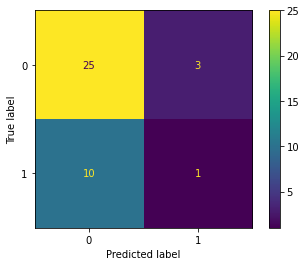

In [41]:
# split X and y from new_input_features before feeding to ANN
new_X_test = genetic_algorithm_new_input_testing_features_prognosis_original.drop(['ground_truth'],axis=1)
new_y_test = genetic_algorithm_new_input_testing_features_prognosis_original['ground_truth']

# predict new X test using pre-trained ANN before
predicted_test_original = genetic_algorithm_ann_model_prognosis_original.predict(new_X_test)

# print testing results
print_model_experiment_results('Hasil Pengujian Data Testing Prognosis Breast Cancer (Original) + Genetic Algorithm ', new_y_test, predicted_test_original)

### Ensemble stacking ML - ANN (without GA)

#### Create New Input Features from stacking ensemble ML before ANN process for preparing testing data new input features

In [42]:
new_input_testing_features_prognosis_original = create_new_input_features(
    ensemble_classifiers_prognosis_original, 
    prognosis_X_test_original,
    prognosis_y_test_original
)

#### Feed new testing input features into ANN pre-trained model

		HASIl UJI COBA HASIL PENGUJIAN DATA TESTING PROGNOSIS BREAST CANCER (ORIGINAL)
	Akurasi Score:  0.7435897435897436
	Macro Recall Score:  0.6282467532467533
	Macro Precision Score:  0.6763392857142857
	Macro F1-score Score:  0.6388888888888888
	Macro F2-score Score:  0.6301062091503267
	Macro F0.5-score Score:  0.6570512820512819


              precision    recall  f1-score   support

           0       0.78      0.89      0.83        28
           1       0.57      0.36      0.44        11

    accuracy                           0.74        39
   macro avg       0.68      0.63      0.64        39
weighted avg       0.72      0.74      0.72        39



<Figure size 1008x576 with 0 Axes>

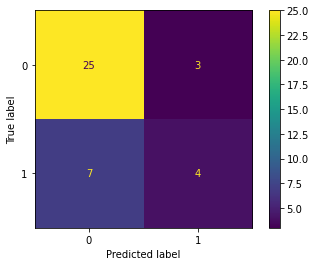

In [43]:
# split X and y from new_input_features before feeding to ANN
new_X_test = new_input_testing_features_prognosis_original.drop(['ground_truth'],axis=1)
new_y_test = new_input_testing_features_prognosis_original['ground_truth']

# predict new X test using pre-trained ANN before
predicted_test_original = ann_model_prognosis_original.predict(new_X_test)

# print testing results
print_model_experiment_results('Hasil Pengujian Data Testing Prognosis Breast Cancer (Original)', new_y_test, predicted_test_original)

## With Data Sampling Method (Upsampling)

### GA combine Ensemble stacking ML - ANN

#### Create New Input Features from stacking ensemble ML before ANN process for preparing testing data new input features

In [44]:
genetic_algorithm_new_input_testing_features_prognosis_upsampling = create_new_input_features(
    genetic_algorithm_ensemble_classifiers_prognosis_upsampling, 
    prognosis_X_test_original,
    prognosis_y_test_original
)

#### Feed new testing input features into ANN pre-trained model

		HASIl UJI COBA HASIL PENGUJIAN DATA TESTING PROGNOSIS BREAST CANCER (UPSAMPLING) + GENETIC ALGORITHM
	Akurasi Score:  0.8205128205128205
	Macro Recall Score:  0.8474025974025974
	Macro Precision Score:  0.7907608695652174
	Macro F1-score Score:  0.8017429193899781
	Macro F2-score Score:  0.824074074074074
	Macro F0.5-score Score:  0.7916666666666666


              precision    recall  f1-score   support

           0       0.96      0.79      0.86        28
           1       0.62      0.91      0.74        11

    accuracy                           0.82        39
   macro avg       0.79      0.85      0.80        39
weighted avg       0.86      0.82      0.83        39



<Figure size 1008x576 with 0 Axes>

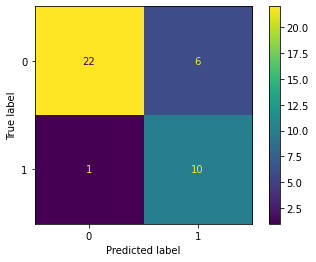

In [45]:
# split X and y from new_input_features before feeding to ANN
new_X_test = genetic_algorithm_new_input_testing_features_prognosis_upsampling.drop(['ground_truth'],axis=1)
new_y_test = genetic_algorithm_new_input_testing_features_prognosis_upsampling['ground_truth']

# predict new X test using pre-trained ANN before
predicted_test_upsampling = genetic_algorithm_ann_model_prognosis_upsampling.predict(new_X_test)

# print testing results
print_model_experiment_results('Hasil Pengujian Data Testing Prognosis Breast Cancer (Upsampling) + Genetic Algorithm', new_y_test, predicted_test_upsampling)

### Ensemble stacking ML - ANN (without GA)

#### Create New Input Features from stacking ensemble ML before ANN process for preparing testing data new input features

In [46]:
new_input_testing_features_prognosis_upsampling = create_new_input_features(
    ensemble_classifiers_prognosis_upsampling, 
    prognosis_X_test_original,
    prognosis_y_test_original
)

#### Feed new testing input features into ANN pre-trained model

		HASIl UJI COBA HASIL PENGUJIAN DATA TESTING PROGNOSIS BREAST CANCER (UPSAMPLING)
	Akurasi Score:  0.7948717948717948
	Macro Recall Score:  0.7467532467532467
	Macro Precision Score:  0.7467532467532467
	Macro F1-score Score:  0.7467532467532467
	Macro F2-score Score:  0.7467532467532467
	Macro F0.5-score Score:  0.7467532467532467


              precision    recall  f1-score   support

           0       0.86      0.86      0.86        28
           1       0.64      0.64      0.64        11

    accuracy                           0.79        39
   macro avg       0.75      0.75      0.75        39
weighted avg       0.79      0.79      0.79        39



<Figure size 1008x576 with 0 Axes>

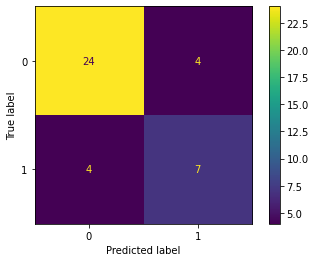

In [47]:
# split X and y from new_input_features before feeding to ANN
new_X_test = new_input_testing_features_prognosis_upsampling.drop(['ground_truth'],axis=1)
new_y_test = new_input_testing_features_prognosis_upsampling['ground_truth']

# predict new X test using pre-trained ANN before
predicted_test_upsampling = ann_model_prognosis_upsampling.predict(new_X_test)

# print testing results
print_model_experiment_results('Hasil Pengujian Data Testing Prognosis Breast Cancer (Upsampling)', new_y_test, predicted_test_upsampling)

## With Data Sampling Method (Downsampling)

### GA combine Ensemble stacking ML - ANN

#### Create New Input Features from stacking ensemble ML before ANN process for preparing testing data new input features

In [48]:
genetic_algorithm_new_input_testing_features_prognosis_downsampling = create_new_input_features(
    genetic_algorithm_ensemble_classifiers_prognosis_downsampling, 
    prognosis_X_test_original,
    prognosis_y_test_original
)

#### Feed new testing input features into ANN pre-trained model

		HASIl UJI COBA HASIL PENGUJIAN DATA TESTING PROGNOSIS BREAST CANCER (DOWNSAMPLING) + GENETIC ALGORITHM
	Akurasi Score:  0.6923076923076923
	Macro Recall Score:  0.7857142857142857
	Macro Precision Score:  0.7391304347826086
	Macro F1-score Score:  0.6871657754010696
	Macro F2-score Score:  0.7229477611940298
	Macro F0.5-score Score:  0.701772899957788


              precision    recall  f1-score   support

           0       1.00      0.57      0.73        28
           1       0.48      1.00      0.65        11

    accuracy                           0.69        39
   macro avg       0.74      0.79      0.69        39
weighted avg       0.85      0.69      0.70        39



<Figure size 1008x576 with 0 Axes>

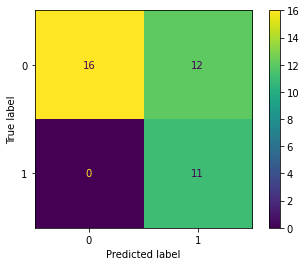

In [49]:
# split X and y from new_input_features before feeding to ANN
new_X_test = genetic_algorithm_new_input_testing_features_prognosis_downsampling.drop(['ground_truth'],axis=1)
new_y_test = genetic_algorithm_new_input_testing_features_prognosis_downsampling['ground_truth']

# predict new X test using pre-trained ANN before
predicted_test_downsampling = genetic_algorithm_ann_model_prognosis_downsampling.predict(new_X_test)

# print testing results
print_model_experiment_results('Hasil Pengujian Data Testing Prognosis Breast Cancer (Downsampling) + Genetic Algorithm', new_y_test, predicted_test_downsampling)

### Ensemble stacking ML - ANN (without GA)

#### Create New Input Features from stacking ensemble ML before ANN process for preparing testing data new input features

In [50]:
new_input_testing_features_prognosis_downsampling = create_new_input_features(
    ensemble_classifiers_prognosis_downsampling, 
    prognosis_X_test_original,
    prognosis_y_test_original
)

#### Feed new testing input features into ANN pre-trained model

		HASIl UJI COBA HASIL PENGUJIAN DATA TESTING PROGNOSIS BREAST CANCER (DOWNSAMPLING)
	Akurasi Score:  0.6666666666666666
	Macro Recall Score:  0.7126623376623377
	Macro Precision Score:  0.6723684210526316
	Macro F1-score Score:  0.6520247083047357
	Macro F2-score Score:  0.6759899809160306
	Macro F0.5-score Score:  0.6559065934065934


              precision    recall  f1-score   support

           0       0.89      0.61      0.72        28
           1       0.45      0.82      0.58        11

    accuracy                           0.67        39
   macro avg       0.67      0.71      0.65        39
weighted avg       0.77      0.67      0.68        39



<Figure size 1008x576 with 0 Axes>

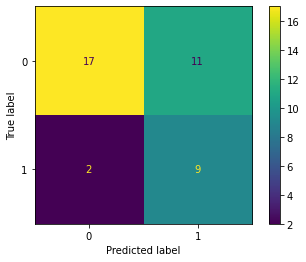

In [51]:
# split X and y from new_input_features before feeding to ANN
new_X_test = new_input_testing_features_prognosis_downsampling.drop(['ground_truth'],axis=1)
new_y_test = new_input_testing_features_prognosis_downsampling['ground_truth']

# predict new X test using pre-trained ANN before
predicted_test_downsampling = ann_model_prognosis_downsampling.predict(new_X_test)

# print testing results
print_model_experiment_results('Hasil Pengujian Data Testing Prognosis Breast Cancer (Downsampling)', new_y_test, predicted_test_downsampling)